# Preliminaries

In [174]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [175]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

warnings.filterwarnings('ignore')

In [176]:
path = "../Datasets/"
Train = pd.read_csv(path + '/Historical-transaction-data.csv')
StoreInfo = pd.read_csv(path + '/Store-info.csv')
Testing = pd.read_csv(path + '/Testing-data.csv')

In [177]:
Train = Train.merge(StoreInfo, on='shop_id', how='left')

In [178]:
Testing.drop("shop_profile", axis=1, inplace=True)


In [179]:
Submission_testing = Testing.copy()
Submission_testing = Submission_testing.merge(Train, on='shop_id', how='left')

In [180]:
Submission_testing.drop("shop_profile", axis=1, inplace=True)

In [181]:
# Train.to_csv('CombinedData.csv', index=False)
# Submission_testing.to_csv('SubmissionData.csv', index=False)

In [182]:
redundant_cols = ['customer_id', 'transaction_date']

Train.drop(redundant_cols, axis=1, inplace=True)
Submission_testing.drop(redundant_cols, axis=1, inplace=True)

In [183]:
features_nom = ['item_description',"shop_id", "shop_profile", "invoice_id"]

for feature in features_nom:
    Train[feature] = Train[feature].astype("category")
    if feature == "shop_profile":
        continue
    Submission_testing[feature] = Submission_testing[feature].astype("category")

# Preprocessing

In [184]:
Train["shop_id"] = Train["shop_id"].str.replace("SHOP", "").astype(int).astype("category")
Submission_testing["shop_id"] = Submission_testing["shop_id"].str.replace("SHOP", "").astype(int).astype("category")
StoreInfo["shop_id"] = StoreInfo["shop_id"].str.replace("SHOP", "").astype(int).astype("category")

In [185]:
#Remove rows with null values for item_description or shop_profile
Train = Train.dropna(subset=['shop_profile'], axis=0)

In [186]:
from sklearn.compose import ColumnTransformer
#import simpleimputer
from sklearn.impute import SimpleImputer

Submission_testing['shop_profile'] = 'default_value'
ct = ColumnTransformer([("SimpleImputer", SimpleImputer(strategy="constant", fill_value="missing"), ["item_description"])], remainder="passthrough")

Train = pd.DataFrame(ct.fit_transform(Train), columns=Train.columns)

Submission_testing = pd.DataFrame(ct.transform(Submission_testing), columns=Train.columns)

In [187]:
# Replace values in the "item_description" column of the Train dataframe
Train['item_description'] = Train['item_description'].str.lower()
Train.loc[Train['item_description'].str.contains('milk', case=False), 'item_description'] = 'MILK'
Train.loc[Train['item_description'].str.contains('water', case=False), 'item_description'] = 'WATER'
Train.loc[Train['item_description'].str.contains('missing', case=False), 'item_description'] = 'MISSING'
Train.loc[~Train['item_description'].str.contains('MILK|WATER|MISSING', case=False), 'item_description'] = 'DRINK'

# Replace values in the "item_description" column of the Submission_testing dataframe
Submission_testing['item_description'] = Submission_testing['item_description'].str.lower()
Submission_testing.loc[Submission_testing['item_description'].str.contains('milk', case=False), 'item_description'] = 'MILK'
Submission_testing.loc[Submission_testing['item_description'].str.contains('water', case=False), 'item_description'] = 'WATER'
Submission_testing.loc[Submission_testing['item_description'].str.contains('missing', case=False), 'item_description'] = 'MISSING'
Submission_testing.loc[~Submission_testing['item_description'].str.contains('MILK|WATER|MISSING', case=False), 'item_description'] = 'DRINK'

In [188]:
Train.drop_duplicates(inplace=True)
Submission_testing.drop_duplicates(inplace=True)

In [189]:
# drop invoice_id column from both dataframes
Train.drop("invoice_id", axis=1, inplace=True)
Submission_testing.drop(["invoice_id", "shop_profile"], axis=1, inplace=True)

In [190]:
category_columns = ["shop_id", "item_description", "shop_profile"]

for col in Train.columns:
    if col not in category_columns:
        Train[col] = Train[col].astype("int64")
        Submission_testing[col] = Submission_testing[col].astype("int64")
    else:
        Train[col] = Train[col].astype("category")
        if col == "shop_profile":
            continue
        Submission_testing[col] = Submission_testing[col].astype("category")

In [191]:
# suppose x1 and x3 column should have a minimum of zero, define the acceptable ranges for each column

ranges = {'quantity_sold': (0, np.inf)}

# loop over each column and adjust the values outside the acceptable range

for col, (min_val, max_val) in ranges.items():
    Train[col] = np.clip(Train[col], min_val, max_val)
    Submission_testing[col] = np.clip(Submission_testing[col], min_val, max_val)

In [192]:
def outlier_thresholds(dataframe, column_name, q1=0.05, q2=0.95):
    quartile1 = dataframe[column_name].quantile(0.05)
    quartile3 = dataframe[column_name].quantile(0.95)
    IQR = quartile3 - quartile1
    up_limit = quartile3 + 1.5*IQR
    low_limit = quartile1 - 1.5*IQR
    return low_limit, up_limit

def check_outlier(dataframe, column_name):
    low_limit, up_limit = outlier_thresholds(dataframe, column_name)
    if dataframe[(dataframe[column_name] < low_limit) | (dataframe[column_name] > up_limit)].any(axis=None):
        return True
    else:
        return False
    
def replace_with_thresholds(dataframe, column_name):
    low_limit, up_limit = outlier_thresholds(dataframe, column_name)
    dataframe.loc[(dataframe[column_name] < low_limit), column_name] = low_limit
    dataframe.loc[(dataframe[column_name] > up_limit), column_name] = up_limit
    
def remove_outliers(df):
    numeric_columns = df.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns
    for col in numeric_columns:
        print(col, check_outlier(df, col))
        if check_outlier(df, col):
            replace_with_thresholds(df, col)

In [193]:
Train.kurt(numeric_only=True)

item_price         363.995483
quantity_sold      374.858178
shop_area_sq_ft      2.973588
dtype: float64

In [194]:
Train.describe()

,item_price,quantity_sold,shop_area_sq_ft
count,351762.000000,351762.000000,351762.000000
mean,209.261958,1.945378,632.962836
std,169.497265,1.667743,123.672885
min,35.000000,0.000000,298.000000
25%,100.000000,1.000000,605.000000
50%,220.000000,2.000000,617.000000
75%,220.000000,2.000000,676.000000
max,17400.000000,101.000000,1077.000000


In [195]:
# remove_outliers(Train)
# remove_outliers(Submission_testing)

In [196]:
Train.kurt(numeric_only=True)

item_price         363.995483
quantity_sold      374.858178
shop_area_sq_ft      2.973588
dtype: float64

In [197]:
Train.describe()

,item_price,quantity_sold,shop_area_sq_ft
count,351762.000000,351762.000000,351762.000000
mean,209.261958,1.945378,632.962836
std,169.497265,1.667743,123.672885
min,35.000000,0.000000,298.000000
25%,100.000000,1.000000,605.000000
50%,220.000000,2.000000,617.000000
75%,220.000000,2.000000,676.000000
max,17400.000000,101.000000,1077.000000


In [198]:
# Create price-related features
Train['total_sales']= Train['item_price'] * Train['quantity_sold']
Submission_testing['total_sales']= Submission_testing['item_price'] * Submission_testing['quantity_sold']

In [199]:
# find the maximum item price, maximum quanitity, minimum item price, minimum quantity for each shop_id

train_max_item_price = Train.groupby('shop_id')['item_price'].max()
train_min_item_price = Train.groupby('shop_id')['item_price'].min()
train_max_item_quantity = Train.groupby('shop_id')['quantity_sold'].max()
train_min_item_quantity = Train.groupby('shop_id')['quantity_sold'].min()




In [200]:
sub_max_item_price = Submission_testing.groupby('shop_id')['item_price'].max()
sub_min_item_price = Submission_testing.groupby('shop_id')['item_price'].min()
sub_max_item_quantity = Submission_testing.groupby('shop_id')['quantity_sold'].max()
sub_min_item_quantity = Submission_testing.groupby('shop_id')['quantity_sold'].min()

# Submission_testing['max_item_price'] = Submission_testing['shop_id'].map(max_item_price)
# Submission_testing['min_item_price'] = Submission_testing['shop_id'].map(min_item_price)
# Submission_testing['max_item_quantity'] = Submission_testing['shop_id'].map(max_item_quantity)
# Submission_testing['min_item_quantity'] = Submission_testing['shop_id'].map(min_item_quantity)

In [201]:
# frequency encode the item_description column

item_description_freq = Train.groupby('item_description').size()/len(Train)
# mapping the encoded values to the Train and Submission_testing dataframes
Train['item_description_freq'] = Train['item_description'].map(item_description_freq)
Submission_testing['item_description_freq'] = Submission_testing['item_description'].map(item_description_freq)

In [202]:
# drop the item_description column and month column from both dataframes
Train.drop(["item_description"], axis=1, inplace=True)
Submission_testing.drop(["item_description"], axis=1, inplace=True)

In [203]:
Train.head(100)

,shop_id,item_price,quantity_sold,shop_area_sq_ft,shop_profile,total_sales,item_description_freq
0,8,220,2,678,Moderate,440,0.846726
1,112,220,2,668,Moderate,440,0.846726
2,8,160,2,678,Moderate,320,0.846726
3,8,150,2,678,Moderate,300,0.846726
4,112,210,5,668,Moderate,1050,0.012887
...,...,...,...,...,...,...,...
109,90,70,1,730,Moderate,70,0.082001
111,47,60,1,528,Moderate,60,0.846726
112,47,220,2,528,Moderate,440,0.846726
113,22,60,2,735,High,120,0.846726


In [204]:
# create a new feature for the fraction of  entries by each shop_id
train_shop_id_counts = Train['shop_id'].value_counts(normalize=True)
Train['shop_id_counts'] = Train['shop_id'].map(train_shop_id_counts)

submit_shop_id_counts = Submission_testing['shop_id'].value_counts(normalize=True)
Submission_testing['shop_id_counts'] = Submission_testing['shop_id'].map(submit_shop_id_counts)

In [205]:
# create a feature for the mean item_price by each shop_id

train_shop_price_mean = Train.groupby('shop_id')['item_price'].mean()
Train['shop_price_mean'] = Train['shop_id'].map(train_shop_price_mean)

submit_shop_price_mean = Submission_testing.groupby('shop_id')['item_price'].mean()
Submission_testing['shop_price_mean'] = Submission_testing['shop_id'].map(submit_shop_price_mean)

In [206]:
# Train.to_csv("TrainPP.csv", index=False)
# Submission_testing.to_csv("Submission_testingPP.csv", index=False)

# Aggregation

In [207]:
Train.head()

,shop_id,item_price,quantity_sold,shop_area_sq_ft,shop_profile,total_sales,item_description_freq,shop_id_counts,shop_price_mean
0,8,220,2,678,Moderate,440,0.846726,0.000685,211.286307
1,112,220,2,668,Moderate,440,0.846726,0.006249,205.996360
2,8,160,2,678,Moderate,320,0.846726,0.000685,211.286307
3,8,150,2,678,Moderate,300,0.846726,0.000685,211.286307
4,112,210,5,668,Moderate,1050,0.012887,0.006249,205.996360


In [208]:
# Aggregate X_train_scaled by shop_id and add all the total_sales values and prevent empty values
# Also get the mode  of the item_description_freq column

Train["item_description_freq"] = Train["item_description_freq"].astype("float64")
Submission_testing["item_description_freq"] = Submission_testing["item_description_freq"].astype("float64")

Train["item_description_freq"] = Train["item_description_freq"].astype("float64")
Submission_testing["item_description_freq"] = Submission_testing["item_description_freq"].astype("float64")

# mode is useless as it is same for all the rows
Train_cum = Train.groupby(['shop_id'], sort=False).agg({'total_sales':'sum', 'item_description_freq':'mean'})
Submission_testing_cum = Submission_testing.groupby(['shop_id'], sort='False').agg({'total_sales':'sum', 'item_description_freq':'mean'})

In [209]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 351762 entries, 0 to 387338
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   shop_id                351762 non-null  category
 1   item_price             351762 non-null  int64   
 2   quantity_sold          351762 non-null  int64   
 3   shop_area_sq_ft        351762 non-null  int64   
 4   shop_profile           351762 non-null  category
 5   total_sales            351762 non-null  int64   
 6   item_description_freq  351762 non-null  float64 
 7   shop_id_counts         351762 non-null  category
 8   shop_price_mean        351762 non-null  category
dtypes: category(4), float64(1), int64(4)
memory usage: 17.5 MB


In [210]:
Train_cum.head()

,total_sales,item_description_freq
shop_id,,
8,122895,0.764508
112,1135920,0.746056
55,882065,0.733008
3,1799705,0.739184
71,877060,0.693795


In [211]:

Train_cum = Train_cum.merge(StoreInfo, on='shop_id', how='left')
Train_cum['shop_id_counts'] = Train_cum['shop_id'].map(train_shop_id_counts)
Train_cum['shop_id_counts'] = Train_cum['shop_id_counts'].astype("float64")
Train_cum['shop_price_mean'] = Train_cum['shop_id'].map(train_shop_price_mean)
Train_cum['shop_price_mean'] = Train_cum['shop_price_mean'].astype("float64")

Train_cum['max_item_price'] = Train_cum['shop_id'].map(train_max_item_price)
Train_cum['max_item_price'] = Train_cum['max_item_price'].astype("float64")
Train_cum['min_item_price'] = Train_cum['shop_id'].map(train_min_item_price)
Train_cum['min_item_price'] = Train_cum['min_item_price'].astype("float64")
Train_cum['max_item_quantity'] = Train_cum['shop_id'].map(train_max_item_quantity)
Train_cum['max_item_quantity'] = Train_cum['max_item_quantity'].astype("float64")
Train_cum['min_item_quantity'] = Train_cum['shop_id'].map(train_min_item_quantity)
Train_cum['min_item_quantity'] = Train_cum['min_item_quantity'].astype("float64")
# do the same for submission testing


Submission_testing_cum = Submission_testing_cum.merge(StoreInfo, on='shop_id', how='left')
Submission_testing_cum['shop_id_counts'] = Submission_testing_cum['shop_id'].map(submit_shop_id_counts)
Submission_testing_cum['shop_id_counts'] = Submission_testing_cum['shop_id_counts'].astype("float64")
Submission_testing_cum['shop_price_mean'] = Submission_testing_cum['shop_id'].map(submit_shop_price_mean)
Submission_testing_cum['shop_price_mean'] = Submission_testing_cum['shop_price_mean'].astype("float64")

Submission_testing_cum['max_item_price'] = Submission_testing_cum['shop_id'].map(sub_max_item_price)
Submission_testing_cum['max_item_price'] = Submission_testing_cum['max_item_price'].astype("float64")
Submission_testing_cum['min_item_price'] = Submission_testing_cum['shop_id'].map(sub_min_item_price)
Submission_testing_cum['min_item_price'] = Submission_testing_cum['min_item_price'].astype("float64")
Submission_testing_cum['max_item_quantity'] = Submission_testing_cum['shop_id'].map(sub_max_item_quantity)
Submission_testing_cum['max_item_quantity'] = Submission_testing_cum['max_item_quantity'].astype("float64")
Submission_testing_cum['min_item_quantity'] = Submission_testing_cum['shop_id'].map(sub_min_item_quantity)
Submission_testing_cum['min_item_quantity'] = Submission_testing_cum['min_item_quantity'].astype("float64")
Submission_testing_cum.drop(["shop_profile"], axis=1, inplace=True)

In [212]:
Train_cum.head()

,shop_id,total_sales,item_description_freq,shop_area_sq_ft,shop_profile,shop_id_counts,shop_price_mean,max_item_price,min_item_price,max_item_quantity,min_item_quantity
0,8,122895,0.764508,678,Moderate,0.000685,211.286307,960.0,35.0,16.0,0.0
1,112,1135920,0.746056,668,Moderate,0.006249,205.996360,1920.0,35.0,33.0,0.0
2,55,882065,0.733008,720,Moderate,0.006365,192.159446,1320.0,35.0,16.0,0.0
3,3,1799705,0.739184,810,High,0.009521,214.423709,1870.0,35.0,20.0,0.0
4,71,877060,0.693795,704,Low,0.006408,187.136202,1320.0,35.0,12.0,0.0


In [213]:
# new feature: total_sales per sq ft of the shop
Train_cum['sales_per_sq_ft'] = Train_cum['total_sales'] / Train_cum['shop_area_sq_ft']
Submission_testing_cum['sales_per_sq_ft'] = Submission_testing_cum['total_sales'] / Submission_testing_cum['shop_area_sq_ft']

# new feature : multiplication of the total_sales and total_sales_per_sq_ft
Train_cum['sales_times_shop_area'] = Train_cum['total_sales'] * Train_cum['shop_area_sq_ft']
Submission_testing_cum['sales_times_shop_area'] = Submission_testing_cum['total_sales'] * Submission_testing_cum['shop_area_sq_ft']

In [214]:
Train_cum.describe()

,total_sales,item_description_freq,shop_area_sq_ft,shop_id_counts,shop_price_mean,max_item_price,min_item_price,max_item_quantity,min_item_quantity,sales_per_sq_ft,sales_times_shop_area
count,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.000000,100.0,100.000000,1.000000e+02
mean,2.033379e+06,0.727512,628.290000,0.010000,209.540782,2868.650000,35.0,40.410000,0.0,3366.357722,1.289316e+09
std,8.047619e+05,0.029402,128.999201,0.002957,16.235592,1812.879686,0.0,18.816012,0.0,1539.208762,6.256146e+08
min,1.228950e+05,0.572841,298.000000,0.000685,150.809524,960.000000,35.0,12.000000,0.0,181.261062,8.332281e+07
25%,1.530981e+06,0.714207,573.250000,0.008229,198.617831,1950.000000,35.0,25.000000,0.0,2506.793736,8.558116e+08
50%,1.894988e+06,0.730701,617.000000,0.009909,208.462770,2610.000000,35.0,38.500000,0.0,3100.256462,1.191022e+09
75%,2.518536e+06,0.746506,676.000000,0.011676,218.735418,3225.000000,35.0,50.000000,0.0,4095.282824,1.574806e+09
max,5.784905e+06,0.777821,1077.000000,0.017029,262.783737,17400.000000,35.0,101.000000,0.0,10745.973154,3.868988e+09


In [215]:
Submission_testing_cum.describe()

,total_sales,item_description_freq,shop_area_sq_ft,shop_id_counts,shop_price_mean,max_item_price,min_item_price,max_item_quantity,min_item_quantity,sales_per_sq_ft,sales_times_shop_area
count,2.400000e+01,24.000000,24.000000,24.000000,24.000000,24.000000,24.0,24.000000,24.0,24.000000,2.400000e+01
mean,2.055834e+06,0.731226,585.416667,0.041667,218.990978,2976.250000,35.0,46.416667,0.0,3707.221150,1.194978e+09
std,5.625499e+05,0.034623,112.998236,0.010790,14.550969,892.543081,0.0,22.989443,0.0,1497.527004,3.799535e+08
min,1.072345e+06,0.629791,310.000000,0.022716,196.347483,1600.000000,35.0,14.000000,0.0,1753.930070,5.618021e+08
25%,1.724305e+06,0.715052,529.250000,0.035316,210.146030,2400.000000,35.0,28.750000,0.0,2804.086701,8.704153e+08
50%,2.079385e+06,0.736972,607.000000,0.042703,218.763786,2900.000000,35.0,45.500000,0.0,3488.224276,1.238438e+09
75%,2.481351e+06,0.752665,676.000000,0.046677,230.035006,3390.000000,35.0,51.250000,0.0,4625.959857,1.490490e+09
max,2.936345e+06,0.779407,774.000000,0.065425,243.600829,5600.000000,35.0,100.000000,0.0,8247.129032,1.870452e+09


In [216]:
y_train_main = Train["shop_profile"]
Train.drop("shop_profile", axis=1, inplace=True)

In [217]:
y_train_main = Train_cum["shop_profile"]
Train_cum.drop("shop_profile", axis=1, inplace=True)

# Feature Scaling

In [218]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import StandardScaler

scaled_columns = ["total_sales", "shop_area_sq_ft", "shop_id_counts", "shop_price_mean", "sales_per_sq_ft", "sales_times_shop_area"]
ct = ColumnTransformer([("StandardScaler", StandardScaler(), scaled_columns)], remainder="passthrough")

# scaled_columns = ["total_sales", "shop_area_sq_ft", "shop_id_counts", "shop_price_mean", "sales_per_sq_ft", "sales_times_shop_area"]
# ct = ColumnTransformer([("MinMaxScaler", MinMaxScaler(feature_range=(0, 100)), scaled_columns)], remainder="passthrough")

# Fit and transform only the scaled columns in the training data
scaled_X_train = Train_cum.copy()
scaled_X_train[scaled_columns] = ct.fit_transform(Train_cum[scaled_columns])

# Transform only the scaled columns in the submission testing data
scaled_X_submission = Submission_testing_cum.copy()
scaled_X_submission[scaled_columns] = ct.transform(Submission_testing_cum[scaled_columns])

In [219]:
scaled_X_train.head()

,shop_id,total_sales,item_description_freq,shop_area_sq_ft,shop_id_counts,shop_price_mean,max_item_price,min_item_price,max_item_quantity,min_item_quantity,sales_per_sq_ft,sales_times_shop_area
0,8,-2.385933,0.764508,0.387293,-3.165694,0.108054,960.0,35.0,16.0,0.0,-2.079733,-1.937405
1,112,-1.120803,0.746056,0.309382,-1.274946,-0.219412,1920.0,35.0,33.0,0.0,-1.087748,-0.852273
2,55,-1.437834,0.733008,0.714516,-1.235334,-1.075963,1320.0,35.0,16.0,0.0,-1.398157,-1.051007
3,3,-0.291826,0.739184,1.415710,-0.162912,0.302270,1870.0,35.0,20.0,0.0,-0.747310,0.270603
4,71,-1.444084,0.693795,0.589860,-1.220842,-1.386919,1320.0,35.0,12.0,0.0,-1.384618,-1.079340


In [220]:
# set scaled_X_train shop_id as categorical and other columns as numerical

category_columns = ["shop_id"]

for column in category_columns:
    scaled_X_train[column] = scaled_X_train[column].astype("category")
    scaled_X_submission[column] = scaled_X_submission[column].astype("category")

In [221]:
scaled_X_train.describe()

,total_sales,item_description_freq,shop_area_sq_ft,shop_id_counts,shop_price_mean,max_item_price,min_item_price,max_item_quantity,min_item_quantity,sales_per_sq_ft,sales_times_shop_area
count,1.000000e+02,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,100.000000,100.0,100.000000,100.0,1.000000e+02,1.000000e+02
mean,-6.217249e-17,0.727512,2.745026e-16,-6.250556e-16,-1.076916e-15,2868.650000,35.0,40.410000,0.0,1.876277e-16,7.882583e-17
std,1.005038e+00,0.029402,1.005038e+00,1.005038e+00,1.005038e+00,1812.879686,0.0,18.816012,0.0,1.005038e+00,1.005038e+00
min,-2.385933e+00,0.572841,-2.573302e+00,-3.165694e+00,-3.635663e+00,960.000000,35.0,12.000000,0.0,-2.079733e+00,-1.937405e+00
25%,-6.274257e-01,0.714207,-4.288188e-01,-6.017835e-01,-6.761674e-01,1950.000000,35.0,25.000000,0.0,-5.612587e-01,-6.964170e-01
50%,-1.728315e-01,0.730701,-8.796083e-02,-3.103262e-02,-6.673252e-02,2610.000000,35.0,38.500000,0.0,-1.737528e-01,-1.579080e-01
75%,6.058958e-01,0.746506,3.717105e-01,5.694273e-01,5.691790e-01,3225.000000,35.0,50.000000,0.0,4.759571e-01,4.586340e-01
max,4.685145e+00,0.777821,3.495917e+00,2.388681e+00,3.295918e+00,17400.000000,35.0,101.000000,0.0,4.818575e+00,4.144192e+00


In [222]:
scaled_X_submission.describe()

,total_sales,item_description_freq,shop_area_sq_ft,shop_id_counts,shop_price_mean,max_item_price,min_item_price,max_item_quantity,min_item_quantity,sales_per_sq_ft,sales_times_shop_area
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.0,24.000000,24.0,24.000000,24.000000
mean,0.028044,0.731226,-0.334028,10.762029,0.584999,2976.250000,35.0,46.416667,0.0,0.222569,-0.151552
std,0.702548,0.034623,0.880374,3.666909,0.900754,892.543081,0.0,22.989443,0.0,0.977821,0.610388
min,-1.200200,0.629791,-2.479810,4.321612,-0.816710,1600.000000,35.0,14.000000,0.0,-1.052847,-1.168738
25%,-0.385991,0.715052,-0.771625,8.603680,0.037467,2400.000000,35.0,28.750000,0.0,-0.367139,-0.672956
50%,0.057456,0.736972,-0.165871,11.114227,0.570935,2900.000000,35.0,45.500000,0.0,0.079574,-0.081735
75%,0.559457,0.752665,0.371710,12.464824,1.268662,3390.000000,35.0,51.250000,0.0,0.822467,0.323181
max,1.127682,0.779407,1.135232,18.836516,2.108432,5600.000000,35.0,100.000000,0.0,3.186936,0.933583


In [223]:
# scaled_X_train.to_csv("scaled_X_train.csv", index=False)
# scaled_X_submission.to_csv("scaled_X_submission.csv", index=False)

In [224]:
scaled_X_train.head()

,shop_id,total_sales,item_description_freq,shop_area_sq_ft,shop_id_counts,shop_price_mean,max_item_price,min_item_price,max_item_quantity,min_item_quantity,sales_per_sq_ft,sales_times_shop_area
0,8,-2.385933,0.764508,0.387293,-3.165694,0.108054,960.0,35.0,16.0,0.0,-2.079733,-1.937405
1,112,-1.120803,0.746056,0.309382,-1.274946,-0.219412,1920.0,35.0,33.0,0.0,-1.087748,-0.852273
2,55,-1.437834,0.733008,0.714516,-1.235334,-1.075963,1320.0,35.0,16.0,0.0,-1.398157,-1.051007
3,3,-0.291826,0.739184,1.415710,-0.162912,0.302270,1870.0,35.0,20.0,0.0,-0.747310,0.270603
4,71,-1.444084,0.693795,0.589860,-1.220842,-1.386919,1320.0,35.0,12.0,0.0,-1.384618,-1.079340


# Train Test Split

In [225]:
## Splitting the dataset into the Training set and Test set

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_X_train, y_train_main, test_size = 0.2, random_state = 1)

In [226]:
## Splitting the dataset into the Training set and Test set

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Train_cum, y_train_main, test_size = 0.2, random_state = 1)

In [227]:
# import labelencoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_train_main = le.transform(y_train_main)

In [228]:
# y_train = pd.DataFrame(y_train)
# y_test = pd.DataFrame(y_test)

# Metrics

In [229]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder

def score_classification(model, df1_x, df1_y, df2_x, df2_y):
  print(model)
  df1_x = df1_x.copy()
  df2_x = df2_x.copy() 
  ct2 = ColumnTransformer(transformers=[('encoder', OneHotEncoder(handle_unknown='ignore'), [0])], remainder='passthrough')

  # One hot encoding for the item_description column

  df1_encoded = ct2.fit_transform(df1_x[["shop_id"]])
  df1_x = pd.concat([df1_x.drop("shop_id", axis=1).reset_index(drop=True), pd.DataFrame(df1_encoded.toarray())], axis='columns')

  df2_encoded = ct2.transform(df2_x[["shop_id"]])
  df2_x = pd.concat([df2_x.drop("shop_id", axis=1).reset_index(drop=True), pd.DataFrame(df2_encoded.toarray())], axis='columns')

  # remove the dummy variable trap
  df1_x = df1_x.drop([0], axis=1)
  df2_x = df2_x.drop([0], axis=1)
  
  df1_x.columns = df1_x.columns.astype(str)
  df2_x.columns = df2_x.columns.astype(str)
  # Fit the model  
  model.fit(df1_x, df1_y)

  # Make predictions
  y_pred = model.predict(df2_x)

  # Evaluate the model
  accuracy = accuracy_score(df2_y, y_pred)
  precision = precision_score(df2_y, y_pred,  average='macro')
  recall = recall_score(df2_y, y_pred,  average='macro')
  f1 = f1_score(df2_y, y_pred,  average='macro')

  print(f"Accuracy: {accuracy}")
  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"F1 Score: {f1}")

In [230]:
def outputResult(model, df1_x, df1_y, test, le):
    print(model)
    df1_x = df1_x.copy()
    df2_x = test.copy()
    
    ct2 = ColumnTransformer(transformers=[('encoder', OneHotEncoder(handle_unknown='ignore'), [0])], remainder='passthrough')

    # One hot encoding for the item_description column

    df1_encoded = ct2.fit_transform(df1_x[["shop_id"]])
    df1_x = pd.concat([df1_x.drop("shop_id", axis=1).reset_index(drop=True), pd.DataFrame(df1_encoded.toarray())], axis='columns')

    df2_encoded = ct2.transform(df2_x[["shop_id"]])
    df2_x = pd.concat([df2_x.drop("shop_id", axis=1).reset_index(drop=True), pd.DataFrame(df2_encoded.toarray())], axis='columns')

  # Drop the first column to avoid dummy variable trap
    df1_x = df1_x.drop([0], axis=1)
    df2_x = df2_x.drop([0], axis=1)

    df1_x.columns = df1_x.columns.astype(str)
    df2_x.columns = df2_x.columns.astype(str)
    # Fit the model on the training data
    model.fit(df1_x, df1_y)
    
    # Make predictions on the test data
    y_pred = model.predict(df2_x)
    
    # Inverse transform the encoded predictions to the original shop profiles
    y_pred = le.inverse_transform(y_pred)    
    
    # Create a dataframe with the predicted shop profiles
    results_df = pd.DataFrame({'shop_id': test.shop_id, 'shop_profile': y_pred})    
    # rename the shop_id column with the word "SHOP" and add a 0 in front of the shop_id
    results_df["shop_id"] = results_df["shop_id"].astype(int).astype(str)
    results_df["shop_id"] = "SHOP" + results_df["shop_id"].str.zfill(3)
    # results_df.to_csv('predictions'+str(model).strip("()")+'.csv', index=False)

    # results_df.drop_duplicates(inplace=True)
    
    # Access the global testing dataframe
    results_final = pd.merge(Testing, results_df, on="shop_id", how="left")
    # Write the dataframe to a CSV file
    results_final.to_csv('predictions'+str(model).strip("()")+'.csv', index=False)

# Modelling

In [231]:
from sklearn.linear_model import LogisticRegression

logr = LogisticRegression()

In [232]:
score_classification(logr, X_train, y_train, X_test, y_test)

LogisticRegression()
Accuracy: 0.15
Precision: 0.0909090909090909
Recall: 0.16666666666666666
F1 Score: 0.1176470588235294


In [233]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()

In [132]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 351762 entries, 0 to 387338
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   shop_id                351762 non-null  category
 1   item_price             351762 non-null  int64   
 2   quantity_sold          351762 non-null  int64   
 3   shop_area_sq_ft        351762 non-null  int64   
 4   total_sales            351762 non-null  int64   
 5   item_description_freq  351762 non-null  float64 
 6   shop_id_counts         351762 non-null  category
 7   shop_price_mean        351762 non-null  category
dtypes: category(3), float64(1), int64(4)
memory usage: 17.1 MB


In [283]:
score_classification(dtc, X_train, y_train, X_test, y_test)

DecisionTreeClassifier()
Accuracy: 0.35
Precision: 0.4166666666666667
Recall: 0.5050505050505051
F1 Score: 0.3555555555555556


In [173]:
# outputResult(dtc, Train, y_train_main, Submission_testing, le)

DecisionTreeClassifier()


ValueError: Number of labels=100 does not match number of samples=351762

In [291]:
# import svm

from sklearn import svm

svm = svm.SVC()

score_classification(svm, X_train, y_train, X_test, y_test)

SVC()
Accuracy: 0.2
Precision: 0.13333333333333333
Recall: 0.2222222222222222
F1 Score: 0.16666666666666666


In [ ]:
score_classification(dtc, X_train, y_train, X_test, y_test)

DecisionTreeClassifier()
Accuracy: 0.55
Precision: 0.6555555555555556
Recall: 0.6767676767676768
F1 Score: 0.5538461538461538


In [272]:

score_classification(dtc, X_train, y_train, X_test, y_test)

DecisionTreeClassifier()
Accuracy: 0.4
Precision: 0.4407407407407408
Recall: 0.47979797979797983
F1 Score: 0.4105763517528223


In [292]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rfc = RandomForestClassifier()

In [297]:
score_classification(rfc, X_train, y_train, X_test, y_test)

RandomForestClassifier()
Accuracy: 0.35
Precision: 0.41774891774891776
Recall: 0.47474747474747475
F1 Score: 0.3516483516483517


In [298]:
# Define the hyperparameters to test
rfc_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


In [299]:

# Use grid search cross-validation to find the best hyperparameters
rfc_grid_search = GridSearchCV(estimator=rfc, param_grid=rfc_param_grid, cv=5, n_jobs=-1)
rfc_grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding accuracy score
print("Best Hyperparameters: ", rfc_grid_search.best_params_)
print("Best Accuracy Score: ", rfc_grid_search.best_score_)


Best Hyperparameters:  {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best Accuracy Score:  0.6


In [300]:
rfc.set_params(max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=100)

RandomForestClassifier(max_depth=15, min_samples_leaf=4, min_samples_split=10)

In [312]:
score_classification(rfc, X_train, y_train, X_test, y_test)

RandomForestClassifier(max_depth=15, min_samples_leaf=4, min_samples_split=10)
Accuracy: 0.35
Precision: 0.5370370370370371
Recall: 0.41919191919191917
F1 Score: 0.3194444444444445


In [ ]:
from sklearn.svm import SVC
svm = SVC(kernel='linear', C=1)

In [ ]:
score_classification(svm, X_train, y_train, X_test, y_test)

SVC()
Accuracy: 0.2
Precision: 0.13333333333333333
Recall: 0.2222222222222222
F1 Score: 0.16666666666666666


In [ ]:
outputResult(logr, scaled_X_train, y_train_main, scaled_X_submission, le)

LogisticRegression()


PermissionError: [Errno 13] Permission denied: 'predictionsLogisticRegression.csv'

In [ ]:
X_train.head()

,shop_id,total_sales,item_description_freq,shop_area_sq_ft,shop_id_counts,shop_price_mean,sales_per_sq_ft,sales_times_shop_area
2,55,22.241861,0.733008,54.172015,34.753870,38.597216,16.167289,17.511129
73,9,47.036387,0.693988,48.523748,67.872674,37.837596,36.774054,34.451977
97,126,41.860985,0.728389,3.851091,48.095321,49.468402,70.284863,13.581198
62,118,61.770508,0.743282,40.949936,74.691251,58.078289,53.164042,41.077716
19,75,51.127277,0.723411,52.759949,71.177596,33.969211,37.987021,39.399988


In [ ]:
scaled_X_submission.head()

,shop_id,total_sales,item_description_freq,shop_area_sq_ft,shop_id_counts,shop_price_mean,sales_per_sq_ft,sales_times_shop_area
0,2,74.417635,0.749145,43.517330,334.881012,75.194586,61.901956,51.221704
1,19,57.094614,0.771123,14.505777,264.999260,83.371978,75.137021,24.440040
2,23,56.911408,0.739770,40.949936,284.128040,65.790454,49.002717,37.828579
3,24,32.072160,0.704736,48.523748,200.208233,45.384936,25.077214,23.489012
4,29,47.115683,0.722005,38.382542,262.299634,56.136361,42.063684,30.183006


In [ ]:
outputResult(dtc, X_train, y_train, scaled_X_submission, le)

NameError: name 'scaled_X_submission' is not defined

In [ ]:
# Define the parameter grid for hyperparameter tuning
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100], 
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
              'degree': [2, 3, 4, 5]}


# Initialize the SVM model
svm = SVC()

In [ ]:

# # # Use grid search cross-validation to find the best hyperparameters
# svm_grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, n_jobs=-1)
# svm_grid_search.fit(X_train, y_train)

# # Print the best hyperparameters and the corresponding accuracy score
# print("Best Hyperparameters: ", svm_grid_search.best_params_)
# print("Best Accuracy Score: ", svm_grid_search.best_score_)

In [ ]:
svm.set_params(C=1, gamma=0.1, kernel='linear')

SVC(C=1, gamma=0.1, kernel='linear')

In [ ]:
score_classification(svm, X_train, y_train, X_test, y_test)

SVC()
Accuracy: 0.2
Precision: 0.13333333333333333
Recall: 0.2222222222222222
F1 Score: 0.16666666666666666


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=1)

In [ ]:
score_classification(gbm, X_train, y_train, X_test, y_test)

GradientBoostingClassifier(random_state=1)
Accuracy: 0.45
Precision: 0.47380952380952374
Recall: 0.5353535353535354
F1 Score: 0.4513403263403262


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

In [ ]:
score_classification(knn, X_train, y_train, X_test, y_test)

KNeighborsClassifier()
Accuracy: 0.25
Precision: 0.23148148148148148
Recall: 0.25252525252525254
F1 Score: 0.2222222222222222


In [ ]:
from sklearn.pipeline import Pipeline
import numpy as np

# Define the parameter grid to search over
knn_param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'knn__leaf_size': [10, 20, 30, 40, 50],
    'knn__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
}

# Create a pipeline to preprocess the data and apply KNN
knn_pipeline = Pipeline([ 
    ('knn', KNeighborsClassifier())
])

# Create a grid search object to find the best parameters
knn_grid_search = GridSearchCV(knn_pipeline, knn_param_grid, cv=5, n_jobs=-1)

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=False).split(range(25))

from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='f1_macro')
print(scores)

[0.38888889 0.48888889 0.52380952 0.22222222 0.11111111 0.60555556
 0.31481481 0.33333333 0.3015873  0.32380952]


In [ ]:
# Fit the grid search object on the data
# knn_grid_search.fit(X_train, y_train)

# # Print the best parameters found
# print("Best parameters:", knn_grid_search.best_params_)


In [ ]:
# Set the best parameters found by GridSearchCV
knn.set_params(**{'algorithm': 'auto', 'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 11, 'p': 1, 'weights': 'distance'})

score_classification(knn, X_train, y_train, X_test, y_test)

KNeighborsClassifier(leaf_size=10, metric='manhattan', n_neighbors=11, p=1,
                     weights='distance')
Accuracy: 0.4
Precision: 0.4166666666666667
Recall: 0.44949494949494945
F1 Score: 0.38759018759018765


In [ ]:
scores = cross_val_score(rfc, X_train, y_train, cv=10, scoring='accuracy')
print(scores)

[0.5   0.375 0.5   0.5   0.25  0.625 0.75  0.375 0.5   0.5  ]


In [ ]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

In [ ]:
score_classification(nb, X_train, y_train, X_test, y_test)

GaussianNB()
Accuracy: 0.35
Precision: 0.4385964912280702
Recall: 0.3636363636363636
F1 Score: 0.21555555555555553


In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, max_depth=5)

In [ ]:
score_classification(xgb_model, X_train, y_train, X_test, y_test)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
Accuracy: 0.25
Precision: 0.3333333333333333
Recall: 0.2272727272727273
F1 Score: 0.26515151515151514


In [ ]:
# Create a list of classifiers to compare
classifiers = [logr, dtc, knn, rfc, nb, svm, gbm]

# Create X and y data

# Cross-validation
for clf in classifiers:
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=lambda clf, X, y: f1_score(y, clf.predict(X), average='macro'))
    print(clf.__class__.__name__)
    print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


LogisticRegression
F1 Score: 0.52 (+/- 0.06)
DecisionTreeClassifier
F1 Score: 0.38 (+/- 0.26)
KNeighborsClassifier
F1 Score: 0.44 (+/- 0.10)
RandomForestClassifier
F1 Score: 0.51 (+/- 0.19)
GaussianNB
F1 Score: 0.52 (+/- 0.34)
SVC
F1 Score: 0.57 (+/- 0.19)
GradientBoostingClassifier
F1 Score: 0.48 (+/- 0.29)


# Feature Engineering

In [ ]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X,y):
  X = X.copy()
  for colname in X.select_dtypes(["object", "category"]):
    X[colname], _ = X[colname].factorize()
  # all discrete features should now have integer dtypes
  discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
  mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
  mi_scores = pd.Series(mi_scores, name="Mutual Information Scores", index=X.columns)
  mi_scores = mi_scores.sort_values(ascending=False)
  return mi_scores


def plot_mi_scores(scores):
  scores = scores.sort_values(ascending=True)
  width = np.arange(len(scores))
  ticks = list(scores.index)
  plt.barh(width,scores)
  plt.yticks(width, ticks)
  plt.title("Mututal Information Scores")

In [ ]:
X_train_mi = X_train.copy()
#convert all columns to float
for col in X_train_mi.columns:
    X_train_mi[col] = X_train_mi[col].astype("float64")
#     X

# X_test_mi["shop_id"] = X_test_mi["shop_id"].astype("float64")64
# 

In [ ]:
mi_scores = make_mi_scores(X_train_mi, y_train)
mi_scores

sales_times_shop_area    0.183477
min_item_quantity        0.159205
sales_per_sq_ft          0.154989
shop_id_counts           0.145977
max_item_quantity        0.106308
shop_area_sq_ft          0.078044
min_item_price           0.072026
total_sales              0.049087
shop_price_mean          0.045456
shop_id                  0.025841
item_description_freq    0.024278
max_item_price           0.014260
Name: Mutual Information Scores, dtype: float64

In [ ]:
from sklearn.decomposition import PCA

def apply_pca(X):
  pca= PCA()
  df1_x = X.copy()

  X_pca = pca.fit_transform(df1_x)
  component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
  X_pca = pd.DataFrame(X_pca, columns=component_names)
  #create loadings
  loadings = pd.DataFrame(
  pca.components_.T,
  columns = component_names,
  index=df1_x.columns,
  )
  return pca, X_pca, loadings

def plot_variance(pca, width=8, dpi=100):
  fig, axs = plt.subplots(1,2)
  n = pca.n_components_
  grid = np.arange(1, n+1)
  evr = pca.explained_variance_ratio_
  axs[0].bar(grid,evr)
  axs[0].set(
      xlabel="Component",title="% Explained Variance", ylim=(0.0,1.0)             )
  #Cumulative Variance
  cv = np.cumsum(evr)
  axs[1].plot(np.r_[0,grid], np.r_[0,cv], "o-")
  axs[1].set(xlabel="Component", title="% Cumulatve Variance", ylim=(0.0, 1.0))
  fig.set(figwidth=8, dpi=100)
  return axs

In [ ]:
pca, X_pca, loadings = apply_pca(X_train_mi)
print(loadings)

                                PC1           PC2           PC3       PC4  \
shop_id                9.623610e-09 -8.795096e-06 -5.044747e-03  0.004084   
total_sales            1.284585e-03  9.999899e-01 -1.762415e-03 -0.003917   
item_description_freq -4.771068e-12  1.708008e-08 -3.326549e-06 -0.000014   
shop_area_sq_ft        8.376307e-08 -2.867503e-04  4.119479e-04  0.018974   
shop_id_counts         3.809034e-12  2.268978e-09 -8.385837e-07 -0.000002   
shop_price_mean        6.044283e-09  1.065870e-05 -6.421798e-04  0.002788   
max_item_price         2.191586e-06  1.921488e-03  9.991480e-01  0.040887   
min_item_price         0.000000e+00  0.000000e+00 -8.077936e-28  0.000000   
max_item_quantity      1.573337e-08  1.726202e-05  1.106999e-03  0.010946   
min_item_quantity      0.000000e+00  0.000000e+00 -0.000000e+00  0.000000   
sales_per_sq_ft        1.453579e-06  3.848102e-03 -4.090116e-02  0.998904   
sales_times_shop_area  9.999992e-01 -1.284583e-03  1.337068e-07  0.000003   

In [ ]:
 # plot a pairplot for all the features
y_train_df = pd.DataFrame(y_train, columns=['target'])
# X_train.index = range(len(X_train))
# combine X_train and y_train into a single dataframe
df_concat = pd.concat([X_train, y_train_df], axis=1)

KeyboardInterrupt: 

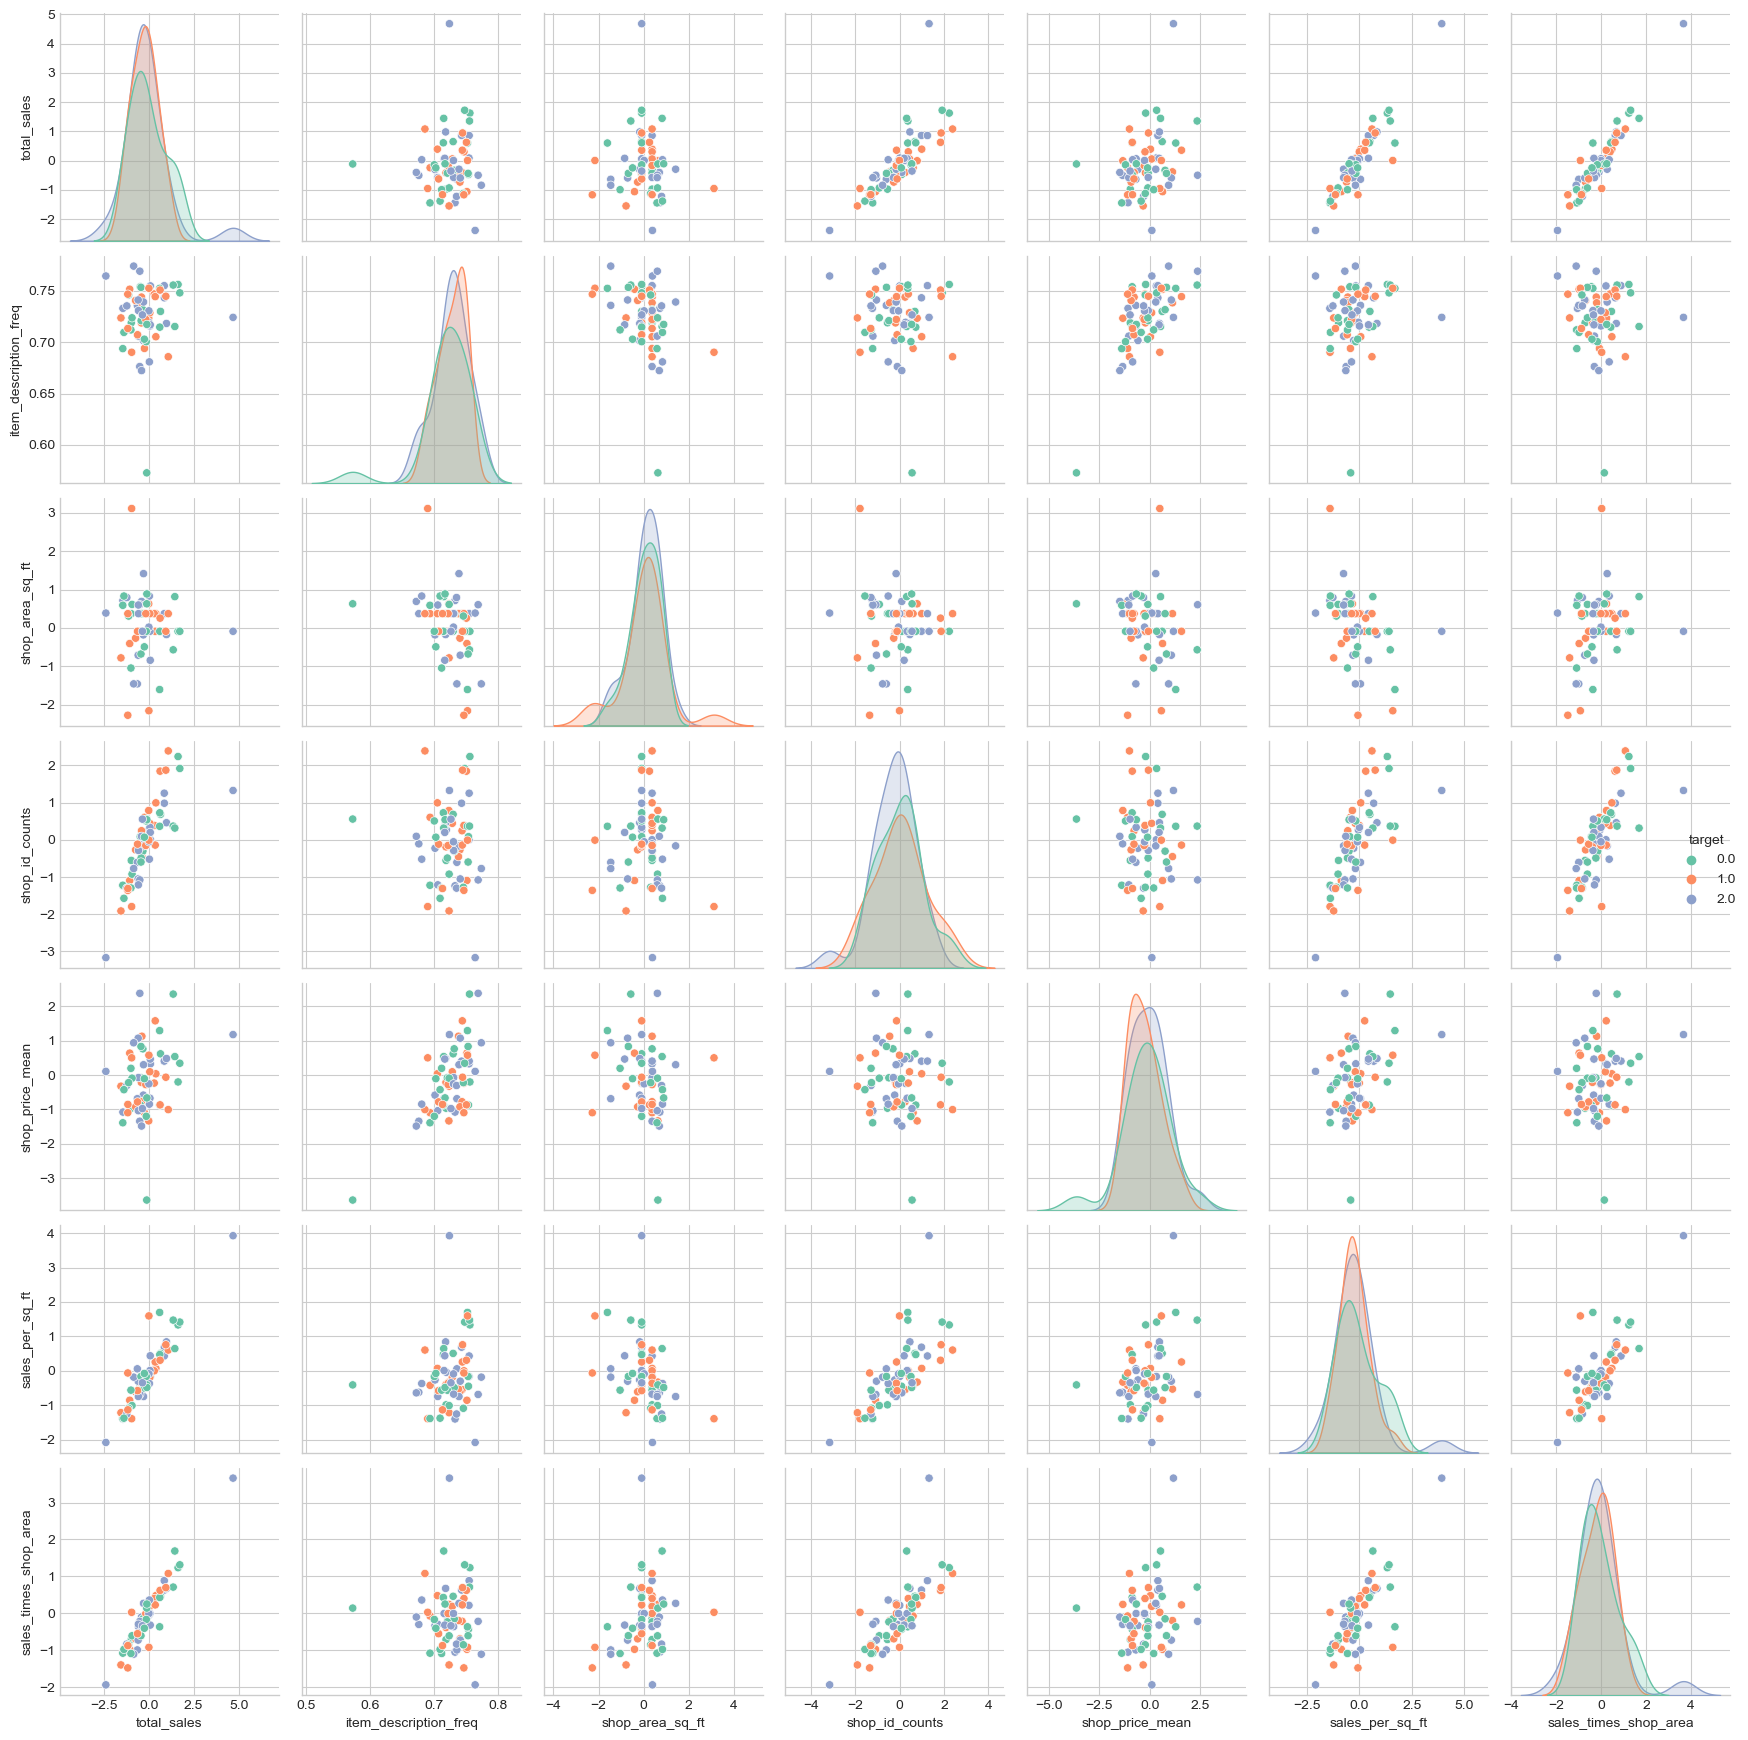

In [ ]:
# Define a custom color palette
custom_palette = sns.color_palette("Set2")

# Plot the pairplot with the custom palette
sns.pairplot(df_concat, hue='target', palette=custom_palette)

# Clustering

In [ ]:
from sklearn.cluster import KMeans

def cluster_labels(df, features, n_clusters=6):
  X = df.copy()
  X_new = X.loc[:, features]
  kmeans = KMeans(n_clusters=n_clusters, n_init=100, random_state=0)
  X_new["Cluster"] = kmeans.fit_predict(X_new)
  X_new["Cluster"] = X_new.Cluster.astype("category")
  return X_new

In [ ]:
def plot_cluster(X, y):
  Xy = X.copy()
  Xy["y"] = y
  Xy.head()
  sns.relplot(
      x="value", y="y", hue="Cluster", col="variable",
      height=4, aspect=1, facet_kws={'sharex':False}, col_wrap=3,
      data=Xy.melt(
          value_vars=features, id_vars=["y", "Cluster"]
      )
  )

In [ ]:
features = X_train.columns
cluster_df1_x = cluster_labels(X_train, features, n_clusters=3)
cluster_df2_x = cluster_labels(X_test, features, n_clusters=3)
# cluster_df3_x = cluster_labels(Submission_testing, features, n_clusters=3)
cluster_df1_x.head()

,shop_id,total_sales,item_description_freq,shop_area_sq_ft,shop_id_counts,shop_price_mean,sales_per_sq_ft,sales_times_shop_area,Cluster
2,55,22.241861,0.733008,54.172015,34.753870,38.597216,16.167289,17.511129,0
73,9,47.036387,0.693988,48.523748,67.872674,37.837596,36.774054,34.451977,0
97,126,41.860985,0.728389,3.851091,48.095321,49.468402,70.284863,13.581198,1
62,118,61.770508,0.743282,40.949936,74.691251,58.078289,53.164042,41.077716,2
19,75,51.127277,0.723411,52.759949,71.177596,33.969211,37.987021,39.399988,2


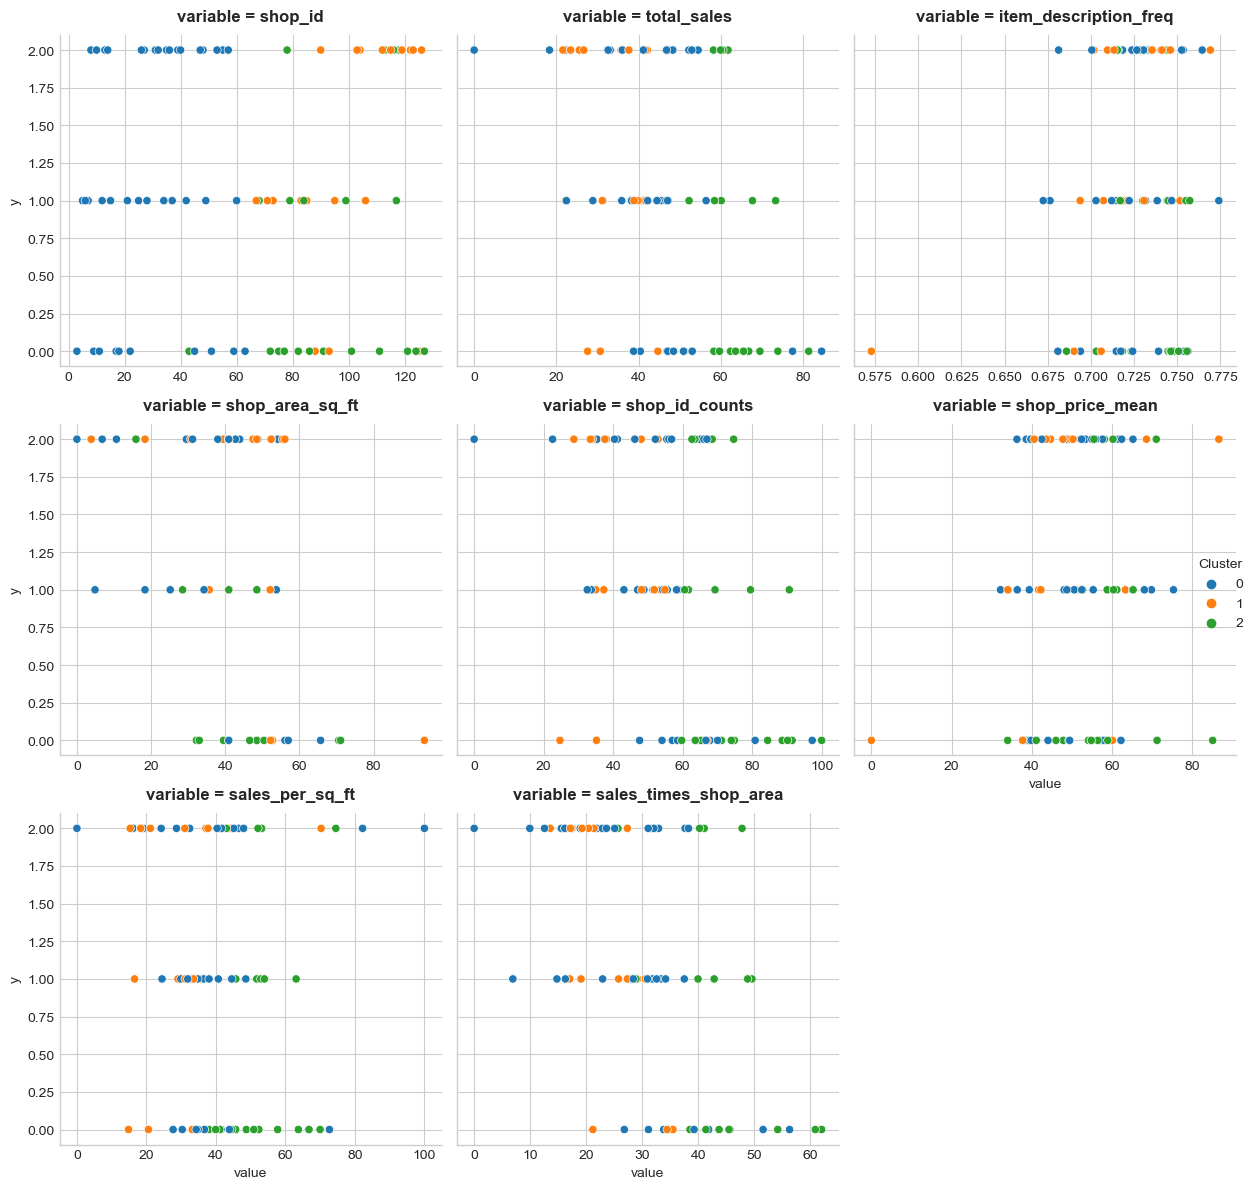

In [ ]:
plot_cluster(cluster_df1_x, y_train)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 2 to 37
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   shop_id                80 non-null     category
 1   total_sales            80 non-null     float64 
 2   item_description_freq  80 non-null     float64 
 3   shop_area_sq_ft        80 non-null     float64 
 4   shop_id_counts         80 non-null     float64 
 5   shop_price_mean        80 non-null     float64 
 6   sales_per_sq_ft        80 non-null     float64 
 7   sales_times_shop_area  80 non-null     float64 
dtypes: category(1), float64(7)
memory usage: 12.0 KB


In [ ]:
score_classification(svm, cluster_df1_x, y_train, cluster_df2_x, y_test)

SVC(C=1, gamma=0.1, kernel='linear')
Accuracy: 0.7
Precision: 0.625
Recall: 0.6313131313131313
F1 Score: 0.6140350877192983


In [ ]:
cluster_df1_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 2 to 37
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   shop_id                80 non-null     category
 1   total_sales            80 non-null     float64 
 2   item_description_freq  80 non-null     float64 
 3   shop_area_sq_ft        80 non-null     float64 
 4   shop_id_counts         80 non-null     float64 
 5   shop_price_mean        80 non-null     float64 
 6   sales_per_sq_ft        80 non-null     float64 
 7   sales_times_shop_area  80 non-null     float64 
 8   Cluster                80 non-null     category
dtypes: category(2), float64(7)
memory usage: 12.2 KB


In [ ]:
cluster_df1_x['shop_id'] = cluster_df1_x['shop_id'].astype('float64')

In [ ]:
mi_scores = make_mi_scores(cluster_df1_x, y_train)
mi_scores

sales_times_shop_area    0.269816
shop_id_counts           0.151098
total_sales              0.079332
sales_per_sq_ft          0.048735
shop_id                  0.030198
shop_area_sq_ft          0.029603
item_description_freq    0.024278
shop_price_mean          0.000000
Cluster                  0.000000
Name: Mutual Information Scores, dtype: float64

In [ ]:
cluster_df1_x.drop(['shop_price_mean'], axis=1, inplace=True)
cluster_df2_x.drop(['shop_price_mean'], axis=1, inplace=True)

In [ ]:
cluster_df1_x.drop(columns=['item_description_freq', 'shop_id_counts'], axis=1, inplace=True)
cluster_df2_x.drop(columns=['item_description_freq', 'shop_id_counts'], axis=1, inplace=True)

In [ ]:
score_classification(svm, cluster_df1_x, y_train, cluster_df2_x, y_test)

SVC(C=1, gamma=0.1, kernel='linear')
Accuracy: 0.25
Precision: 0.3333333333333333
Recall: 0.25252525252525254
F1 Score: 0.2417582417582418


# Dimensionality Reduction

In [ ]:
corr = X_train.corr()
corr.style.background_gradient(cmap='coolwarm')

,total_sales,item_description_freq,shop_area_sq_ft,shop_id_counts,shop_price_mean,max_item_price,min_item_price,max_item_quantity,min_item_quantity,sales_per_sq_ft,sales_times_shop_area
total_sales,1.000000,0.003231,0.002795,0.763308,0.313654,0.728703,nan,0.592796,nan,0.823401,0.903274
item_description_freq,0.003231,1.000000,-0.264136,-0.027670,0.619900,-0.096365,nan,-0.094171,nan,0.098636,-0.095002
shop_area_sq_ft,0.002795,-0.264136,1.000000,0.064234,-0.129286,-0.026757,nan,-0.044660,nan,-0.479863,0.399571
shop_id_counts,0.763308,-0.027670,0.064234,1.000000,-0.056053,0.299019,nan,0.337270,nan,0.554202,0.720622
shop_price_mean,0.313654,0.619900,-0.129286,-0.056053,1.000000,0.194381,nan,0.075907,nan,0.338011,0.229788
max_item_price,0.728703,-0.096365,-0.026757,0.299019,0.194381,1.000000,nan,0.492170,nan,0.596694,0.643266
min_item_price,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
max_item_quantity,0.592796,-0.094171,-0.044660,0.337270,0.075907,0.492170,nan,1.000000,nan,0.569407,0.497928
min_item_quantity,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
sales_per_sq_ft,0.823401,0.098636,-0.479863,0.554202,0.338011,0.596694,nan,0.569407,nan,1.000000,0.515792


In [ ]:
pca, X_pca, loadings = apply_pca(X_train_mi)
print(loadings)

                                PC1           PC2           PC3       PC4  \
shop_id                9.623610e-09 -8.795096e-06 -5.044747e-03  0.004084   
total_sales            1.284585e-03  9.999899e-01 -1.762415e-03 -0.003917   
item_description_freq -4.771068e-12  1.708008e-08 -3.326549e-06 -0.000014   
shop_area_sq_ft        8.376307e-08 -2.867503e-04  4.119479e-04  0.018974   
shop_id_counts         3.809034e-12  2.268978e-09 -8.385837e-07 -0.000002   
shop_price_mean        6.044283e-09  1.065870e-05 -6.421798e-04  0.002788   
max_item_price         2.191586e-06  1.921488e-03  9.991480e-01  0.040887   
min_item_price         0.000000e+00  0.000000e+00 -8.077936e-28  0.000000   
max_item_quantity      1.573337e-08  1.726202e-05  1.106999e-03  0.010946   
min_item_quantity      0.000000e+00  0.000000e+00 -0.000000e+00  0.000000   
sales_per_sq_ft        1.453579e-06  3.848102e-03 -4.090116e-02  0.998904   
sales_times_shop_area  9.999992e-01 -1.284583e-03  1.337068e-07  0.000003   

In [ ]:
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]

In [ ]:
def create_features(df,y, df_test=None, y_test=None):
    X = df.copy()
    y = y.copy()
    mi_scores = make_mi_scores(X, y)

    # Combine splits if test data is given
    #
    # If we're creating features for test set predictions, we should
    # use all the data we have available. After creating our features,
    # we'll recreate the splits.
    if df_test is not None:
        X_test = df_test.copy()
        y_test = y_test.copy()
        X = pd.concat([X, X_test])

    # Lesson 2 - Mutual Information
    X = drop_uninformative(X, mi_scores)

    # Reform splits
    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)

    if df_test is not None:
        return X, X_test
    else:
        return X



In [ ]:

X_train_pca, X_test_pca = create_features(X_train_mi, y_train, X_test_mi, y_test)

In [ ]:
score_classification(knn, X_train_pca, y_train, X_test_pca, y_test)

KNeighborsClassifier(leaf_size=10, metric='manhattan', n_neighbors=11, p=1,
                     weights='distance')
Accuracy: 0.4
Precision: 0.4142857142857143
Recall: 0.42424242424242425
F1 Score: 0.3821428571428571


In [ ]:
pca, X_pca, loadings = apply_pca(X_train_mi)
print(loadings)

                            PC1       PC2       PC3       PC4       PC5  \
shop_id                0.988266  0.118707  0.057088  0.075417 -0.016773   
total_sales            0.079847 -0.527228 -0.061741 -0.125262  0.057888   
item_description_freq -0.000009 -0.000094  0.000511 -0.001125 -0.002706   
shop_area_sq_ft        0.062143  0.055950 -0.750709 -0.248515  0.439088   
shop_id_counts         0.050512 -0.597515 -0.202747  0.296074 -0.522585   
shop_price_mean        0.057401 -0.069936  0.231543 -0.893098 -0.299515   
sales_per_sq_ft        0.039018 -0.474156  0.465042  0.015734  0.663149   
sales_times_shop_area  0.075657 -0.343613 -0.344067 -0.177001  0.031487   

                            PC6       PC7       PC8  
shop_id               -0.002767  0.001728 -0.000017  
total_sales            0.407711 -0.725644 -0.003750  
item_description_freq -0.002753  0.003623 -0.999985  
shop_area_sq_ft       -0.401344 -0.117509 -0.000619  
shop_id_counts        -0.479106  0.094940  0.002696  


In [ ]:
X_train.columns

Index(['shop_id', 'total_sales', 'item_description_freq', 'shop_area_sq_ft',
       'shop_id_counts', 'shop_price_mean', 'max_item_price', 'min_item_price',
       'max_item_quantity', 'min_item_quantity', 'sales_per_sq_ft',
       'sales_times_shop_area'],
      dtype='object')

In [ ]:
pc1 = ['shop_id', 'total_sales', 'item_description_freq', 'shop_area_sq_ft',
       'shop_id_counts', 'shop_price_mean', 'max_item_price',
       'max_item_quantity', 'sales_per_sq_ft',
       'sales_times_shop_area']

In [ ]:
X_train_pca1 = X_train[pc1]
X_test_pca1 = X_test[pc1]

In [ ]:
score_classification(, X_train_pca1, y_train, X_test_pca1, y_test)

KNeighborsClassifier()
Accuracy: 0.25
Precision: 0.23148148148148148
Recall: 0.25252525252525254
F1 Score: 0.2222222222222222


In [ ]:
outputResult(svm, scaled_X_train[pc1], y_train_main, scaled_X_submission[pc1], le)

SVC(C=1, kernel='linear')


In [ ]:
X_submission = scaled_X_submission[pc1]

In [ ]:
X_submission.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 0 to 23
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   shop_id                24 non-null     category
 1   total_sales            24 non-null     float64 
 2   shop_area_sq_ft        24 non-null     float64 
 3   shop_id_counts         24 non-null     float64 
 4   shop_price_mean        24 non-null     float64 
 5   sales_per_sq_ft        24 non-null     float64 
 6   sales_times_shop_area  24 non-null     float64 
dtypes: category(1), float64(6)
memory usage: 2.1 KB


In [ ]:
outputResult(svm, X_train_pca1, y_train, X_submission, le)

SVC(C=1, gamma=0.1, kernel='linear')


In [ ]:
for clf in classifiers:
    scores = cross_val_score(clf, X_train_pca1, y_train, cv=5, scoring=lambda clf, X, y: f1_score(y, clf.predict(X), average='macro'))
    print(clf.__class__.__name__)
    print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

LogisticRegression
F1 Score: 0.53 (+/- 0.28)
DecisionTreeClassifier
F1 Score: 0.46 (+/- 0.30)
KNeighborsClassifier
F1 Score: 0.52 (+/- 0.16)
RandomForestClassifier
F1 Score: 0.56 (+/- 0.25)
GaussianNB
F1 Score: 0.55 (+/- 0.35)
SVC
F1 Score: 0.56 (+/- 0.17)
GradientBoostingClassifier
F1 Score: 0.38 (+/- 0.13)


In [ ]:
score_classification(dtc, X_train_pca1, y_train, X_test_pca1, y_test)

DecisionTreeClassifier()
Accuracy: 0.3
Precision: 0.26851851851851855
Recall: 0.3080808080808081
F1 Score: 0.26666666666666666


In [ ]:
outputResult(rfc, X_train_pca1, y_train, X_submission, le)

RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=10)


In [ ]:
pc2 = ['shop_id', 'total_sales', 'shop_price_mean',
       'shop_id_counts', 'sales_per_sq_ft',
       'sales_times_shop_area']


In [ ]:
X_train_pca2 = X_train[pc2]
X_test_pca2 = X_test[pc2]

In [ ]:
score_classification(dtc, X_train_pca2, y_train, X_test_pca2, y_test)

DecisionTreeClassifier()
Accuracy: 0.3
Precision: 0.26851851851851855
Recall: 0.3080808080808081
F1 Score: 0.26666666666666666


In [ ]:
for clf in classifiers:
    scores = cross_val_score(clf, X_train_pca2, y_train, cv=5, scoring=lambda clf, X, y: f1_score(y, clf.predict(X), average='macro'))
    print(clf.__class__.__name__)
    print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

LogisticRegression
F1 Score: 0.52 (+/- 0.25)
DecisionTreeClassifier
F1 Score: 0.47 (+/- 0.28)
KNeighborsClassifier
F1 Score: 0.48 (+/- 0.15)
RandomForestClassifier
F1 Score: 0.55 (+/- 0.24)
GaussianNB
F1 Score: 0.52 (+/- 0.20)
SVC
F1 Score: 0.57 (+/- 0.18)
GradientBoostingClassifier
F1 Score: 0.42 (+/- 0.10)


In [ ]:
pc3 = ['shop_id', 'shop_area_sq_ft',
       'shop_id_counts', 'shop_price_mean', 'sales_per_sq_ft',
       'sales_times_shop_area']

In [ ]:
X_train_pca3 = X_train[pc3]
X_test_pca3 = X_test[pc3]

In [ ]:
score_classification(svm, X_train_pca3, y_train, X_test_pca3, y_test)

SVC(C=1, gamma=0.1, kernel='linear')
Accuracy: 0.6
Precision: 0.5972222222222222
Recall: 0.5707070707070707
F1 Score: 0.547463429816371


In [ ]:
for clf in classifiers:
    scores = cross_val_score(clf, X_train_pca3, y_train, cv=5, scoring=lambda clf, X, y: f1_score(y, clf.predict(X), average='macro'))
    print(clf.__class__.__name__)
    print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

LogisticRegression
F1 Score: 0.55 (+/- 0.30)
DecisionTreeClassifier
F1 Score: 0.46 (+/- 0.28)
KNeighborsClassifier
F1 Score: 0.53 (+/- 0.20)
RandomForestClassifier
F1 Score: 0.51 (+/- 0.28)
GaussianNB
F1 Score: 0.55 (+/- 0.31)
SVC
F1 Score: 0.53 (+/- 0.19)
GradientBoostingClassifier
F1 Score: 0.39 (+/- 0.07)


## Simplified Model

In [ ]:
X_train.columns

Index(['shop_id', 'total_sales', 'item_description_freq', 'shop_area_sq_ft',
       'shop_id_counts', 'shop_price_mean', 'sales_per_sq_ft',
       'sales_times_shop_area'],
      dtype='object')

In [ ]:
simplified_features = ['shop_id', 'total_sales', 'shop_area_sq_ft',
       'shop_id_counts', 'shop_price_mean', 'sales_per_sq_ft',
       'sales_times_shop_area']

X_train_simple = X_train[simplified_features]
X_test_simple = X_test[simplified_features]

In [ ]:
score_classification(svm, X_train_simple, y_train, X_test_simple, y_test)

SVC(C=1, gamma=0.1, kernel='linear')
Accuracy: 0.7
Precision: 0.625
Recall: 0.6313131313131313
F1 Score: 0.6140350877192983


In [ ]:
X_train.drop(columns=['shop_area_sq_ft'], axis=1, inplace=True)
X_test.drop(columns=['shop_area_sq_ft'], axis=1, inplace=True)
for clf in classifiers:
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=lambda clf, X, y: f1_score(y, clf.predict(X), average='macro'))
    print(clf.__class__.__name__)
    print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


LogisticRegression
F1 Score: 0.52 (+/- 0.25)
DecisionTreeClassifier
F1 Score: 0.48 (+/- 0.21)
KNeighborsClassifier
F1 Score: 0.48 (+/- 0.15)
RandomForestClassifier
F1 Score: 0.58 (+/- 0.14)
GaussianNB
F1 Score: 0.51 (+/- 0.23)
SVC
F1 Score: 0.57 (+/- 0.18)
GradientBoostingClassifier
F1 Score: 0.43 (+/- 0.14)


In [ ]:
score_classification(knn, X_train, y_train, X_test, y_test)

KNeighborsClassifier(leaf_size=10, metric='manhattan', n_neighbors=11, p=1,
                     weights='distance')
Accuracy: 0.5
Precision: 0.404040404040404
Recall: 0.404040404040404
F1 Score: 0.404040404040404


In [ ]:
X_train.drop(columns=['order_count', 'unique_items'], axis=1, inplace=True)
X_test.drop(columns=['order_count', 'unique_items'], axis=1, inplace=True)


KeyError: "['order_count', 'unique_items'] not found in axis"

In [ ]:
for clf in classifiers:
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=lambda clf, X, y: f1_score(y, clf.predict(X), average='macro'))
    print(clf.__class__.__name__)
    print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
# scaled_X_submission = scaled_X_submission[X_train.columns]
# outputResult(gbm, X_train, y_train, scaled_X_submission, le)

In [ ]:
# Define the hyperparameters to test
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}



In [ ]:
# Use grid search cross-validation to find the best hyperparameters
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding accuracy score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy Score: ", grid_search.best_score_)

In [ ]:
# rfc.set_params(**grid_search.best_params_)

In [ ]:
score_classification(rfc, X_train, y_train, X_test, y_test)

In [ ]:
# Fit the grid search object on the data
# grid_search_knn.fit(X_train, y_train)


In [ ]:

# Print the best parameters found
# print("Best parameters:", grid_search_knn.best_params_)

In [ ]:
# knn.set_params(**{'algorithm': 'auto', 'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 11, 'p': 1, 'weights': 'uniform'})
knn.set_params(**{'algorithm': 'auto', 'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'})


In [ ]:
X_train.head()

In [ ]:
score_classification(dtc, X_train, y_train, X_test, y_test)

In [ ]:
score_classification(knn, X_train, y_train, X_test, y_test)

In [ ]:
score_classification(nb, X_train, y_train, X_test, y_test)

In [ ]:
score_classification(dtc, X_train, y_train, X_test, y_test)

In [ ]:
scaled_X_submission = scaled_X_submission[X_train.columns]

In [ ]:
outputResult(knn, X_train, y_train, scaled_X_submission, le)